In [11]:
import ipywidgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio
from tqdm.auto import tqdm

In [12]:
import yaml

In [13]:
%matplotlib inline
plt.style.use('dark_background')
pio.templates.default = 'plotly_dark'

In [14]:
with open ('sample.yaml', 'r') as fid:
    msg = yaml.load(fid, yaml.Loader)

In [9]:
msg.keys()

dict_keys(['header', 'angle_min', 'angle_max', 'angle_increment', 'time_increment', 'scan_time', 'range_min', 'range_max', 'ranges', 'intensities'])

In [15]:
r = np.array(msg['ranges'])
r.shape

(1081,)

In [16]:
theta = np.arange(1081) * msg['angle_increment'] + msg['angle_min']
theta

array([-2.3561945 , -2.35183117, -2.34746785, ...,  2.3474678 ,
        2.35183112,  2.35619445], shape=(1081,))

The block width determines how the angle $\phi$ (in steps of `angle_increment`) the car would be at distance $l$ when driving in direction $\theta$. Therefore, the distance the car can travel anywhere within this angle span $\theta\pm\phi$ can be no higher than $l$, because the car would hit the obstruction at this point.

$sin(\phi) * l <= width_{car}$

$\phi <= asin(\frac{width_{car}}{l})$

In [17]:
car_width = 0.15  # meters to side from center

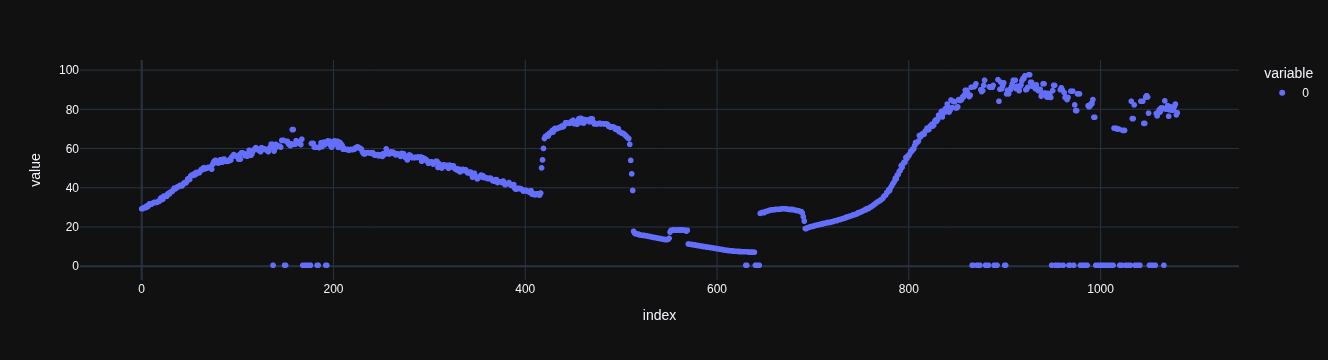

In [19]:
phi = np.arcsin(car_width / r) / msg['angle_increment']
px.scatter(phi)

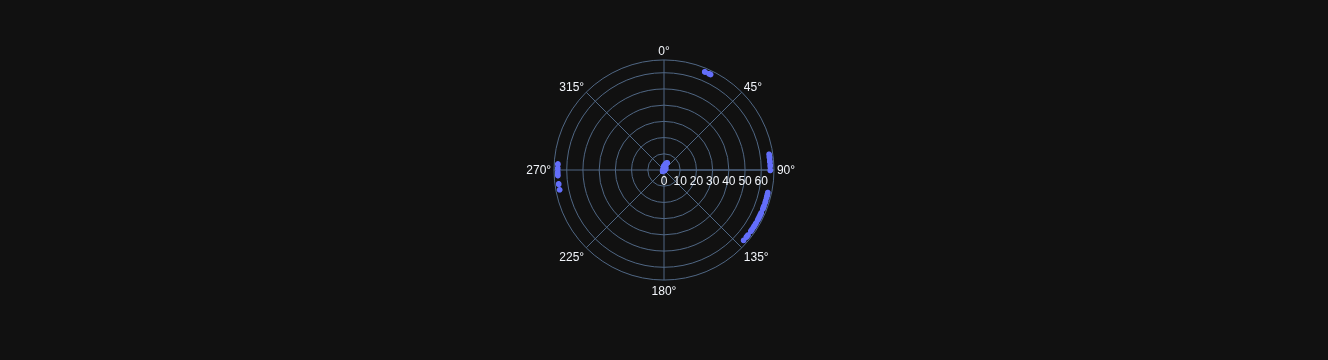

In [25]:
px.scatter_polar(r=r, theta=np.degrees(theta))

In [27]:
phi_to_neighbors = np.arange(1081)[:, np.newaxis] - np.arange(1081)
phi_to_neighbors

array([[    0,    -1,    -2, ..., -1078, -1079, -1080],
       [    1,     0,    -1, ..., -1077, -1078, -1079],
       [    2,     1,     0, ..., -1076, -1077, -1078],
       ...,
       [ 1078,  1077,  1076, ...,     0,    -1,    -2],
       [ 1079,  1078,  1077, ...,     1,     0,    -1],
       [ 1080,  1079,  1078, ...,     2,     1,     0]],
      shape=(1081, 1081))

The object at angle $\theta_n$ obstructs neighbor $\theta_{n+k}$ if $\phi_n <= |k|$

In [28]:
obstructed = np.abs(phi_to_neighbors) <= phi

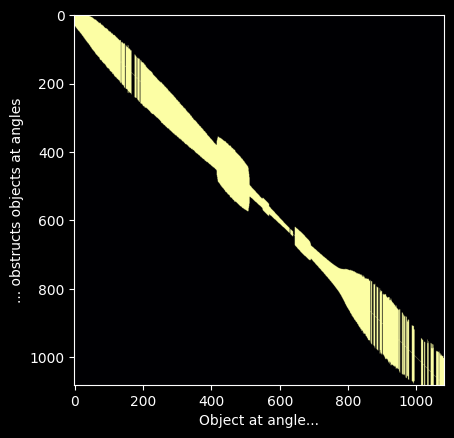

In [29]:
fig, ax = plt.subplots()
ax.set(xlabel='Object at angle...', ylabel='... obstructs objects at angles')
ax.imshow(obstructed, cmap='inferno')

In [30]:
blocking = np.where(obstructed, r, np.nan)

In [34]:
np.nanmax(blocking)

np.float64(65.53299713134766)

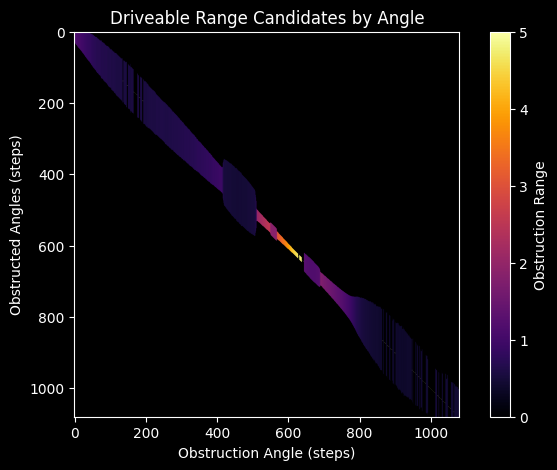

In [41]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.set(
    xlabel='Obstruction Angle (steps)',
    ylabel='Obstructed Angles (steps)',
    title='Driveable Range Candidates by Angle',
)
im = ax.imshow(blocking, cmap='inferno', vmin=0, vmax=5)
fig.colorbar(im, label='Obstruction Range')
fig.savefig('./resource/obstruction-map.png')

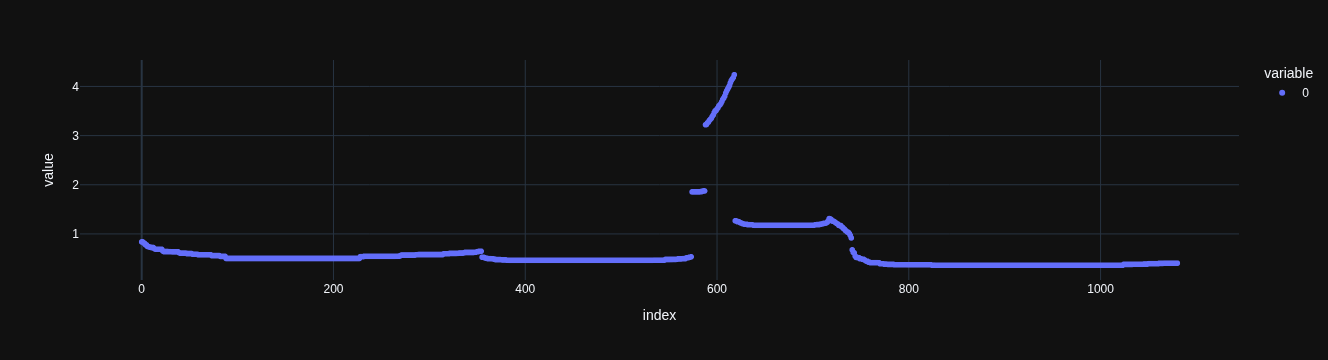

In [37]:
# the effective depth at an angle is the closest distance to any object the car would
# hit at that angle.
effective_depth = np.nanmin(blocking, axis=1)
px.scatter(effective_depth)

In [40]:
index = int(effective_depth.argmax())
direction = theta[index]
distance = effective_depth[index]
print(f'theta[{index}] = {direction}, r[{index}] ~= {distance}')

theta[618] = 0.340339177288115, r[618] ~= 4.23799991607666


In [19]:
is_deepest = np.diff((effective_depth == effective_depth.max()).astype(int))
is_deepest

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  1,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0])

In [20]:
(is_deepest.argmin() + is_deepest.argmax() - 1) / 2

np.float64(107.5)

In [21]:
class BestDirectionFinder:

    angle_min = -2.356194496154785
    angle_max = 2.356194496154785
    angle_increment = 0.0043633230961859
    range_min = 0.0199999995529651
    range_max = 30.0

    def __init__(
        self,
        car_size: float = 0.15,  # meters
        nsamples: int = None,
        **kwargs,  # constants about the scan, such as angle_max. etc.
    ):
        self.__dict__.update(kwargs)
        self.car_size = car_size
        self.nsamples = nsamples or abs(int((self.angle_max + self.angle_min) / self.angle_increment))

        # 2x2 matrix where [phi0, phi1] == phi - phi1
        step = np.arange(self.nsamples)
        self.delta_phi = np.abs(step[:, np.newaxis] - step)

        # we can save time mapping elements to angles by doing it once
        self.theta = np.linspace(self.angle_min, self.angle_max, self.nsamples)

    def get_obstruction_matrix(self, r):
        phi = np.arcsin(self.car_size / r) / self.angle_increment  # in steps
        return np.where(self.delta_phi <= phi, r, r[:, np.newaxis])

    def get_obstructed_distance(self, r):
        return self.get_obstruction_matrix(r).min(axis=1)

    def get_drive_angle(self, r):
        d = self.get_obstructed_distance(r)
        bounds = np.diff((d == d.max()).astype(int))  # +1 entering deeoest region, -1 after exiting
        return (bounds.argmin() + bounds.argmax() - 1) / 2

In [22]:
finder = BestDirectionFinder(nsamples=128)

In [23]:
drive_angle = [finder.get_drive_angle(r) for r in tqdm(rs)]

  0%|          | 0/155 [00:00<?, ?it/s]

In [24]:
rs.shape

(155, 128)

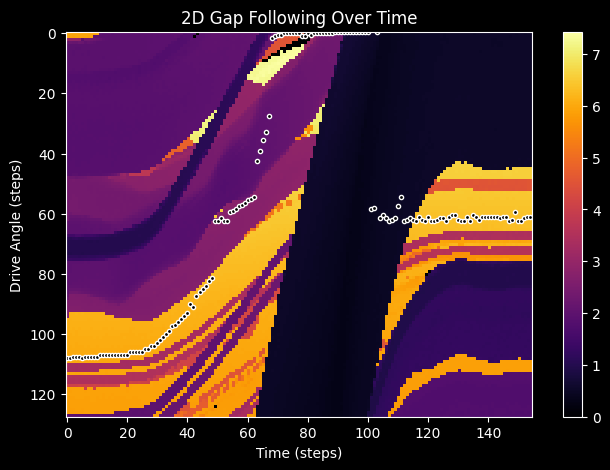

In [25]:
X = rs.T
X[(X < finder.range_min) | (X > finder.range_max)] = np.nan

fig, ax  = plt.subplots(figsize=(8, 5))
ax.set(xlabel='Time (steps)', ylabel='Drive Angle (steps)', title='2D Gap Following Over Time')

im = ax.imshow(X, cmap='inferno', vmin=0)
fig.colorbar(im, ax=ax)

ax.scatter(x=range(len(drive_angle)), y=drive_angle, marker='.', c='black', edgecolors='white')

fig.savefig('./resource/drive-strategy.png')